# Converting Depth Pro to CoreML

Depth Pro is a fast and very accurate monocular depth estimation model by Apple. You can find more details in the [model card](https://huggingface.co/apple/DepthPro) and the [GitHub project](https://github.com/apple/ml-depth-pro).

This notebook shows how to convert it to Core ML for use on Apple Silicon. A Mac computer is required.

## Depth Pro Overview

DepthPro is a monocular depth estimation model, which means it can predict depth based on just a single RGB image.

This is a summary of the architecture (taken from [the original paper](https://arxiv.org/abs/2410.02073)).

![depthpro](images/model_architecture.png)

Notice that the architecture takes in a fixed-size input image of $1536 \times 1536$. In the original repository, images with other resolutions are first bilinearly downscaled to $1536 \times 1536$, then after going through the network the results are bilinearly upscaled back into the original size.

The most confusing part of this diagram is the part around the "Patch Encoder". The patch encoder is a DINOv2 style model (specifically [this one](https://huggingface.co/timm/vit_large_patch14_dinov2.lvd142m/tree/main)), which takes in the 35 $384 \times 384$ RGB patches and processes each patch into 576 $32 \times 32$ sub patches. Then the output of the patch encoder is reshaped back to 35 $24 \times 24$ 1024 color patches. The outputs are then merged back into the first 3 feature maps corresponding to the 3 scales of the images. The last two feature maps are created by taking intermediate layers from the patch encoder.

The output of the model predicts depth in a "canonical" coordinate system, along with a prediction for the field of view (FOV) in degrees. Given the original width of the input image and the focal length (which can be derived from the FOV), we can adjust the model's canonical camera representation to measure depth in real-world units (meters).

Here is a diagram of a pinhole camera for reference:

![pinhole](images/pinhole.jpg)

## Depth Pro PyTorch

Before converting to Core ML, we need to load the model in PyTorch from the original implementation. You can use your favorite python package manager to install everything in the `requirements.txt` file.

First we will import the necessary libraries.

In [1]:
from huggingface_hub import PyTorchModelHubMixin
from depth_pro.depth_pro import (
    create_backbone_model,
    DepthPro,
    DepthProEncoder,
    MultiresConvDecoder,
)
import torch
from torchvision.transforms import Compose, Normalize, ToTensor

from PIL import Image

import numpy as np

import coremltools as ct
import coremltools.optimize as cto
from coremltools.converters.mil import Builder as mb
from coremltools.converters.mil import register_torch_op
from coremltools.converters.mil.frontend.torch.ops import _get_inputs
import numpy as np

import time
import os

from coremlprofiler import CoreMLProfiler

Torch version 2.5.1 has not been tested with coremltools. You may run into unexpected errors. Torch 2.4.0 is the most recent version that has been tested.


Now we will make sure that PyTorch is only using 1 thread because we'll disable gradients globally, but it only affects the current thread. If you don't do this, the notebook could use over 50 Gb of memory.

In [2]:
torch.set_grad_enabled(False)
torch.set_num_threads(1)

On Apple Silicon Macs, we can use the `mps` (Metal Performance Shaders) Pytorch device.

In [3]:
device = (
    torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
)

Now we are going to create the DepthPro model using a mixin from [here](https://huggingface.co/apple/DepthPro-mixin).

We are going to create two wrappers for the model:
- The normalized inverse depth model (`DepthProInvDepthNormalized`) will essentially be a debug model, which outputs a normalized depth map (white is the closest to the camera, and black is the furthest from the camera).
- The other model (`DepthProMeters`) will output the depth in meters. It, however, requires more input params and doesn't play well with the Xcode preview UI.

These wrappers define the inputs and outputs that will be accepted by the converted Core ML models.

In [4]:
class DepthProWrapper(DepthPro, PyTorchModelHubMixin):
    """Depth Pro network."""

    def __init__(
        self,
        patch_encoder_preset: str,
        image_encoder_preset: str,
        decoder_features: str,
        fov_encoder_preset: str,
        use_fov_head: bool = True,
        **kwargs,
    ):
        """Initialize Depth Pro."""

        patch_encoder, patch_encoder_config = create_backbone_model(
            preset=patch_encoder_preset
        )
        image_encoder, _ = create_backbone_model(preset=image_encoder_preset)

        fov_encoder = None
        if use_fov_head and fov_encoder_preset is not None:
            fov_encoder, _ = create_backbone_model(preset=fov_encoder_preset)

        dims_encoder = patch_encoder_config.encoder_feature_dims
        hook_block_ids = patch_encoder_config.encoder_feature_layer_ids
        encoder = DepthProEncoder(
            dims_encoder=dims_encoder,
            patch_encoder=patch_encoder,
            image_encoder=image_encoder,
            hook_block_ids=hook_block_ids,
            decoder_features=decoder_features,
        )
        decoder = MultiresConvDecoder(
            dims_encoder=[encoder.dims_encoder[0]] + list(encoder.dims_encoder),
            dim_decoder=decoder_features,
        )

        super().__init__(
            encoder=encoder,
            decoder=decoder,
            last_dims=(32, 1),
            use_fov_head=use_fov_head,
            fov_encoder=fov_encoder,
        )


class DepthProMeters(DepthProWrapper):
    @torch.inference_mode
    def forward(self, images, original_widths):
        images_norm = Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])(images)
        canonical_inverse_depth, fov_degrees = super().forward(images_norm)
        fov_radians = torch.deg2rad(fov_degrees)
        focal_length_px = 0.5 * original_widths / torch.tan(0.5 * fov_radians)
        width_focal_length_ratio = original_widths / focal_length_px
        inverse_depth = canonical_inverse_depth * width_focal_length_ratio
        return 1.0 / torch.clamp(inverse_depth, min=1e-4, max=1e4)


class DepthProInvDepthNormalized(DepthProWrapper):
    @torch.inference_mode
    def forward(self, x):
        x_norm = Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])(x)

        canonical_inverse_depth, _ = super().forward(x_norm)

        min_vals = canonical_inverse_depth.amin(dim=(1, 2, 3), keepdim=True)
        max_vals = canonical_inverse_depth.amax(dim=(1, 2, 3), keepdim=True)
        inverse_depth_normalized = (canonical_inverse_depth - min_vals) / (
            max_vals - min_vals
        )

        return inverse_depth_normalized * 255.0

## Tracing

In order to convert to Core ML from PyTorch, we need to trace the wrapped models. 

Tracing means we pass a dummy tensor through the model and record everything that happens to it. Then we play it back and recreate the computational graph. This is important because there can be many things inside of PyTorch models that shouldn't or can't be included in a computation graph, like conditionals, special functions, and side effects.

There is another type of graph recording that works in a similar way called scripting. It is also supported by Core ML, but we won't need to use that here.

In [5]:
# Since we are tracing the model, we don't care about the actual values of the input tensor, only the shape matters.
dummy_image = torch.rand((1, 3, 1536, 1536))
dummy_image = dummy_image.to(device)

dummy_original_widths = torch.tensor([[[[1536]]]])
dummy_original_widths = dummy_original_widths.to(device)

Load the model weights from the hub.

In [6]:
depthpro_pytorch = DepthProMeters.from_pretrained("apple/DepthPro-mixin")
depthpro_pytorch.to(device)
depthpro_pytorch.eval()

traced_model = torch.jit.trace(depthpro_pytorch, (dummy_image, dummy_original_widths))

traced_model = traced_model.to(device)

del depthpro_pytorch

/Users/kb/Documents/webclones/coreml-examples/tutorials/DepthPro/.venv/lib/python3.11/site-packages/depth_pro/depth_pro.py:231: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  assert H == self.img_size and W == self.img_size
/Users/kb/Documents/webclones/coreml-examples/tutorials/DepthPro/.venv/lib/python3.11/site-packages/depth_pro/network/encoder.py:176: TracerWarning: Converting a tensor to a Python float might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  steps = int(math.ceil((image_size - patch_size) / patch_stride)) + 1
/Users/kb/Documents/webclones/coreml-examples/tutorials/DepthPro/.venv/lib/python3.11/si

In [7]:
depthpro_pytorch_inv_depth_norm = DepthProInvDepthNormalized.from_pretrained(
    "apple/DepthPro-mixin"
)
depthpro_pytorch_inv_depth_norm.to(device)
depthpro_pytorch_inv_depth_norm.eval()

traced_model_idn = torch.jit.trace(depthpro_pytorch_inv_depth_norm, (dummy_image,))

traced_model_idn = traced_model_idn.to(device)

del depthpro_pytorch_inv_depth_norm

In our case tracing this model is quite simple. 

As we trace we sometimes get warnings saying that certain parts of the model will not be recorded, or will be recorded as constants. This is expected, and in most cases can be safely ignored.

## Checkpoint 1

In [8]:
torch.jit.save(traced_model, "traced_depthpro_model.pt")
torch.jit.save(traced_model_idn, "traced_depthpro_model_normalized_inverse_depth.pt")

In [9]:
# traced_model = torch.jit.load("traced_depthpro_model.pt")
# traced_model.eval()
# traced_model = traced_model.to(device)
# traced_model_idn = torch.jit.load("traced_depthpro_model_normalized_inverse_depth.pt")
# traced_model_idn.eval()
# traced_model_idn = traced_model.to(device)

## Testing The Traced Model

Now that we have a traced model, let's test it, just to see what the output should look like in the future.

We have most of the preprocessing done inside our model code. Right now, we only have to load and resize the image, and make sure that it is on the correct device.

In [10]:
original_image = Image.open("images/example.jpg")
original_width, _ = original_image.size

In [11]:
resized_image = original_image.resize((1536, 1536))
in_image = ToTensor()(resized_image)
in_image = in_image.unsqueeze(0)
in_image = in_image.to(device)

In [12]:
original_widths = torch.tensor([[[[original_width]]]])
original_widths = original_widths.to(device)

Here's the resized original image for reference.

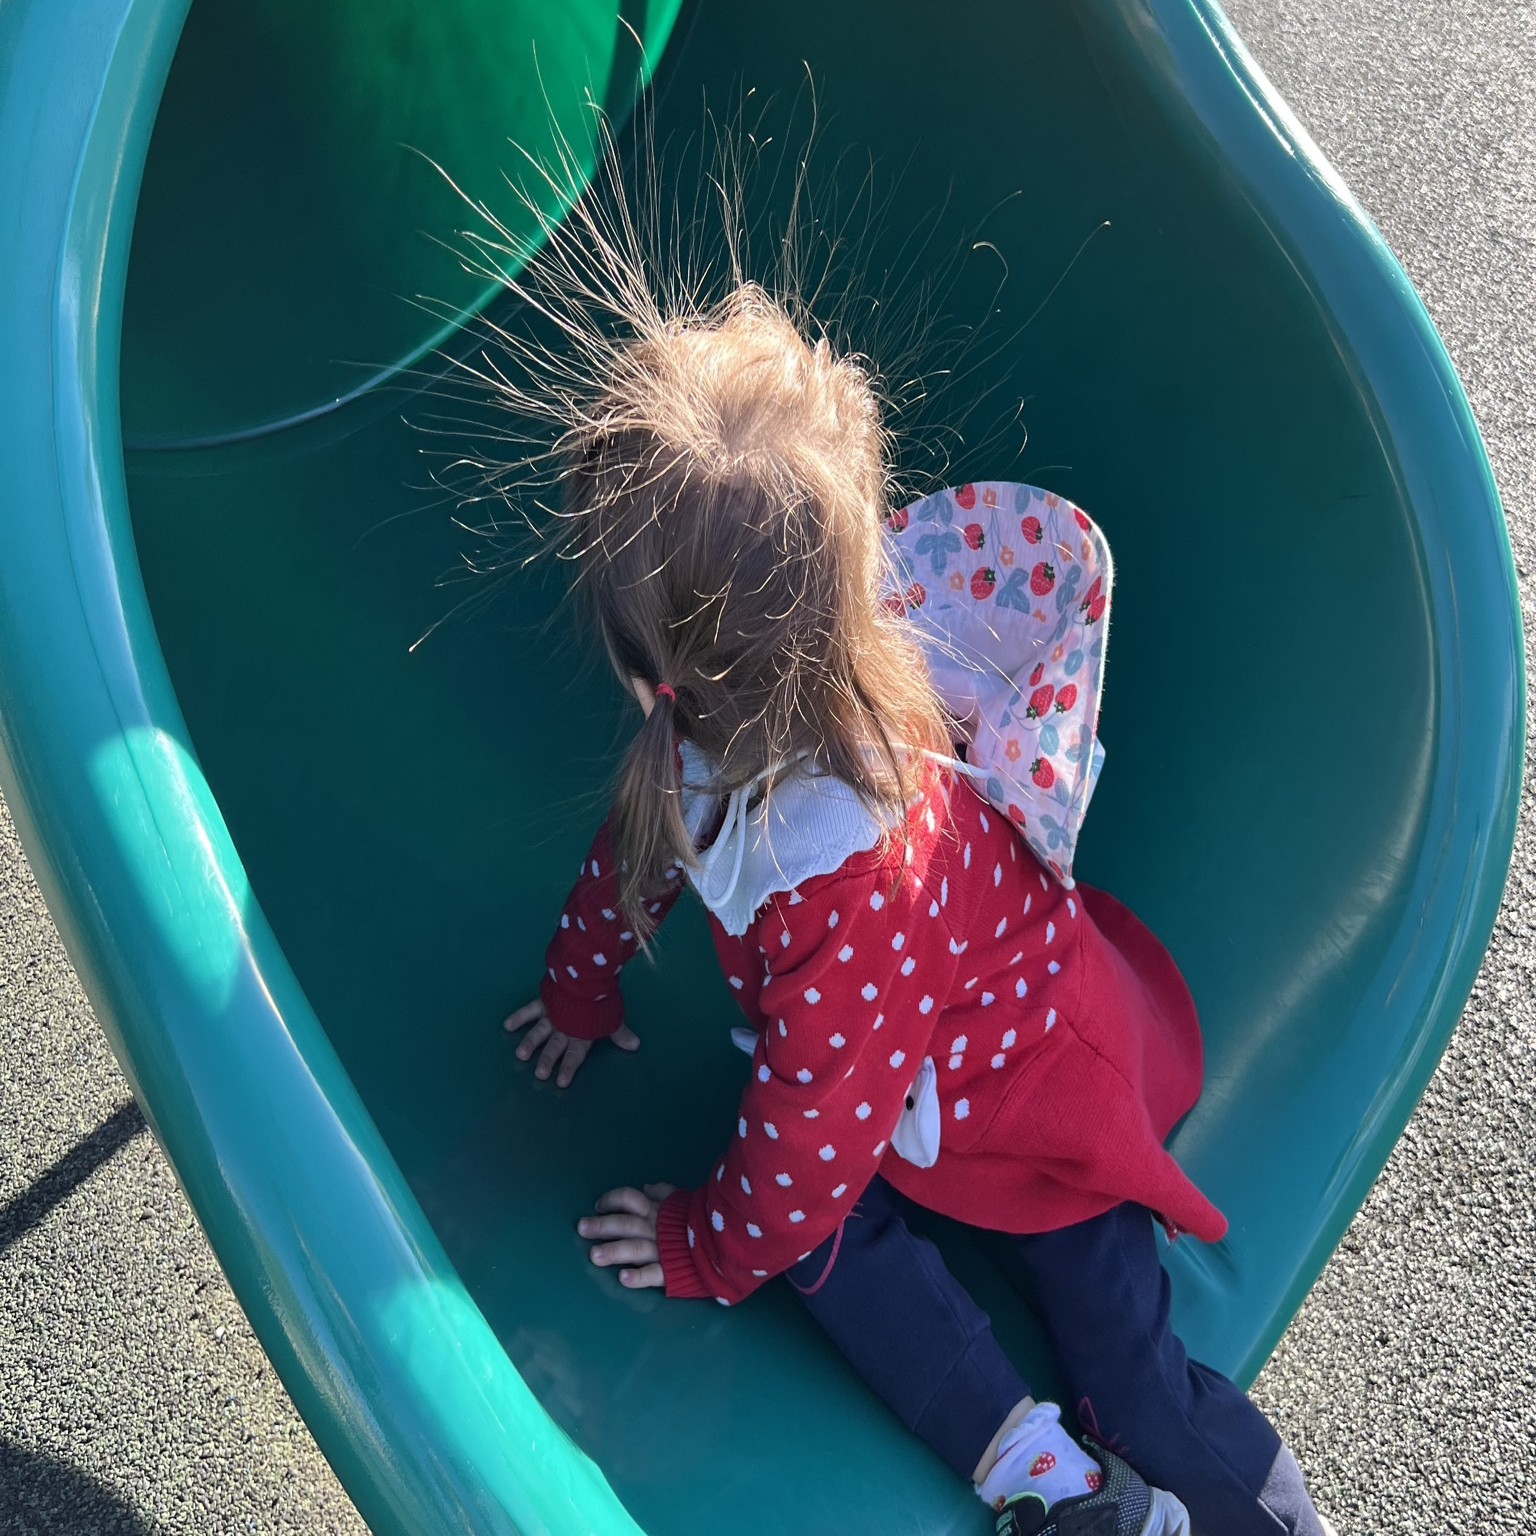

In [13]:
display(resized_image)

Now let's do a test. We manually created a color map for nice visualization of the results.

In [14]:
def array_to_colored_map(elevation_array):
    base_colors = [
        (255, 255, 255),  # 0.0-0.1m: White
        (255, 255, 128),  # 0.1-0.2m: Bright yellow
        (255, 255, 0),  # 0.2-0.3m: Yellow
        (255, 230, 0),  # 0.3-0.4m: Golden yellow
        (255, 200, 0),  # 0.4-0.5m: Orange yellow
        (255, 170, 0),  # 0.5-0.6m: Light orange
        (255, 140, 0),  # 0.6-0.7m: Orange
        (255, 110, 0),  # 0.7-0.8m: Dark orange
        (255, 80, 0),  # 0.8-0.9m: Red orange
        (255, 50, 0),  # 0.9-1.0m: Bright red
        (255, 0, 0),  # 1.0-1.1m: Pure red
        (230, 0, 0),  # 1.1-1.2m: Medium red
        (200, 0, 0),  # 1.2-1.3m: Dark red
        (170, 0, 0),  # 1.3-1.4m: Darker red
        (140, 0, 0),  # 1.4-1.5m: Very dark red
        (128, 0, 128),  # 1.5-1.6m: Purple
        (110, 0, 110),  # 1.6-1.7m: Dark purple
        (90, 0, 90),  # 1.7-1.8m: Darker purple
        (70, 0, 70),  # 1.8-1.9m: Very dark purple
        (50, 0, 50),  # 1.9-2.0m: Almost black purple
        (0, 128, 255),  # 2.0-2.1m: Bright blue
        (0, 100, 230),  # 2.1-2.2m: Medium blue
        (0, 80, 200),  # 2.2-2.3m: Dark blue
        (0, 60, 170),  # 2.3-2.4m: Darker blue
        (0, 40, 140),  # 2.4-2.5m: Very dark blue
        (0, 100, 0),  # 2.5-2.6m: Dark green
        (0, 80, 0),  # 2.6-2.7m: Darker green
        (0, 60, 0),  # 2.7-2.8m: Very dark green
        (0, 40, 0),  # 2.8-2.9m: Almost black green
        (20, 20, 20),  # 2.9-3.0m: Near black
        (15, 15, 15),  # 3.0-3.1m: Darker near black
        (10, 10, 10),  # 3.1-3.2m: Very dark near black
        (5, 5, 5),  # 3.2-3.3m: Almost black
        (2, 2, 2),  # 3.3-3.4m: Almost Pure black
        (0, 0, 0),  # 3.4-3.5m: Pure black
    ]

    scaled_elevation = elevation_array * 10
    int_part = np.clip(scaled_elevation.astype(int), a_min=0, a_max=len(base_colors))

    color_map = np.zeros(
        (elevation_array.shape[0], elevation_array.shape[1], 3), dtype=np.uint8
    )

    for i, bc in enumerate(base_colors):
        base_color = np.array(bc, dtype=np.uint8)
        idxs = int_part == i
        color_map[idxs] = base_color

    return color_map

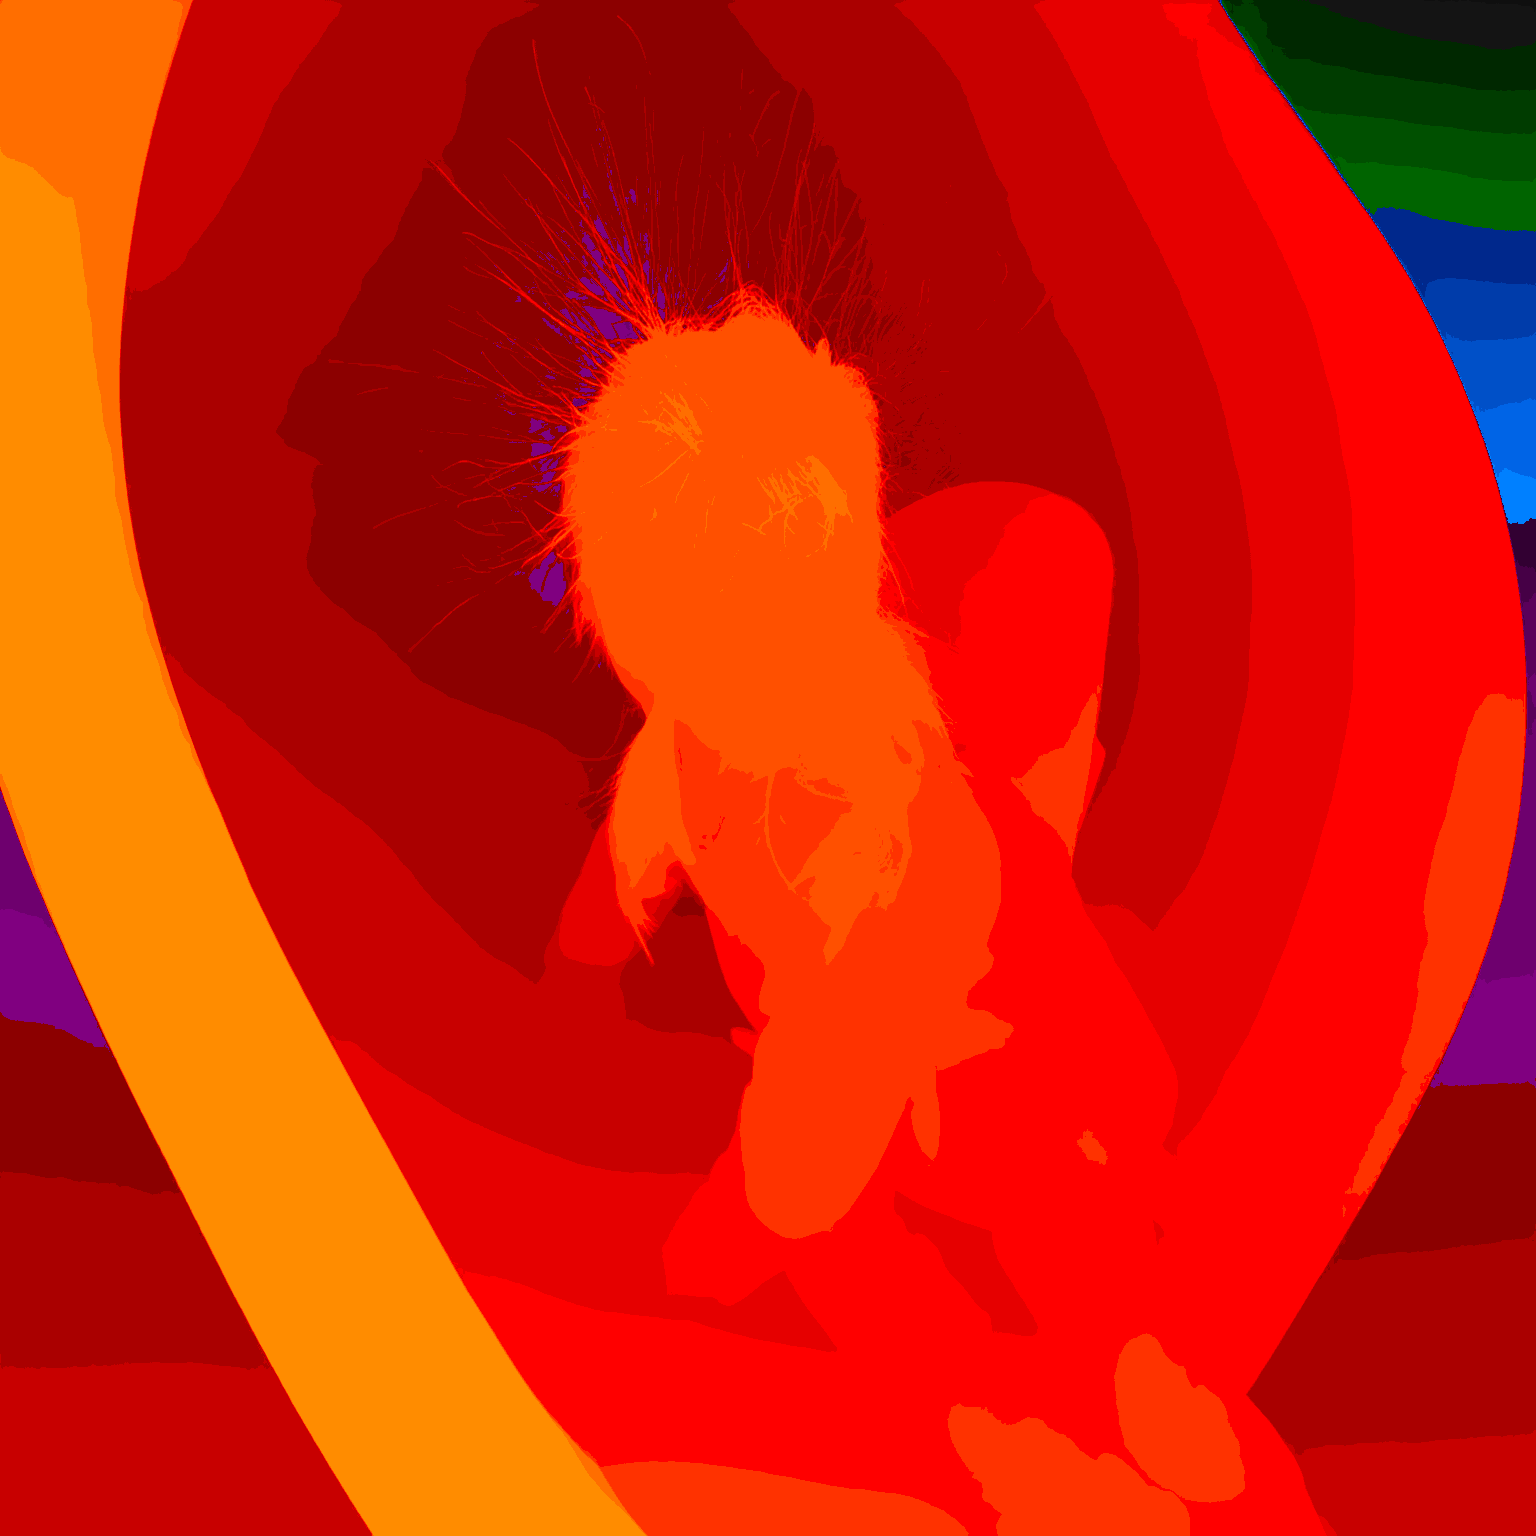

In [15]:
depth_meters = traced_model(in_image, original_widths)
color_map = array_to_colored_map(depth_meters.cpu().numpy().squeeze())
display(Image.fromarray(color_map))

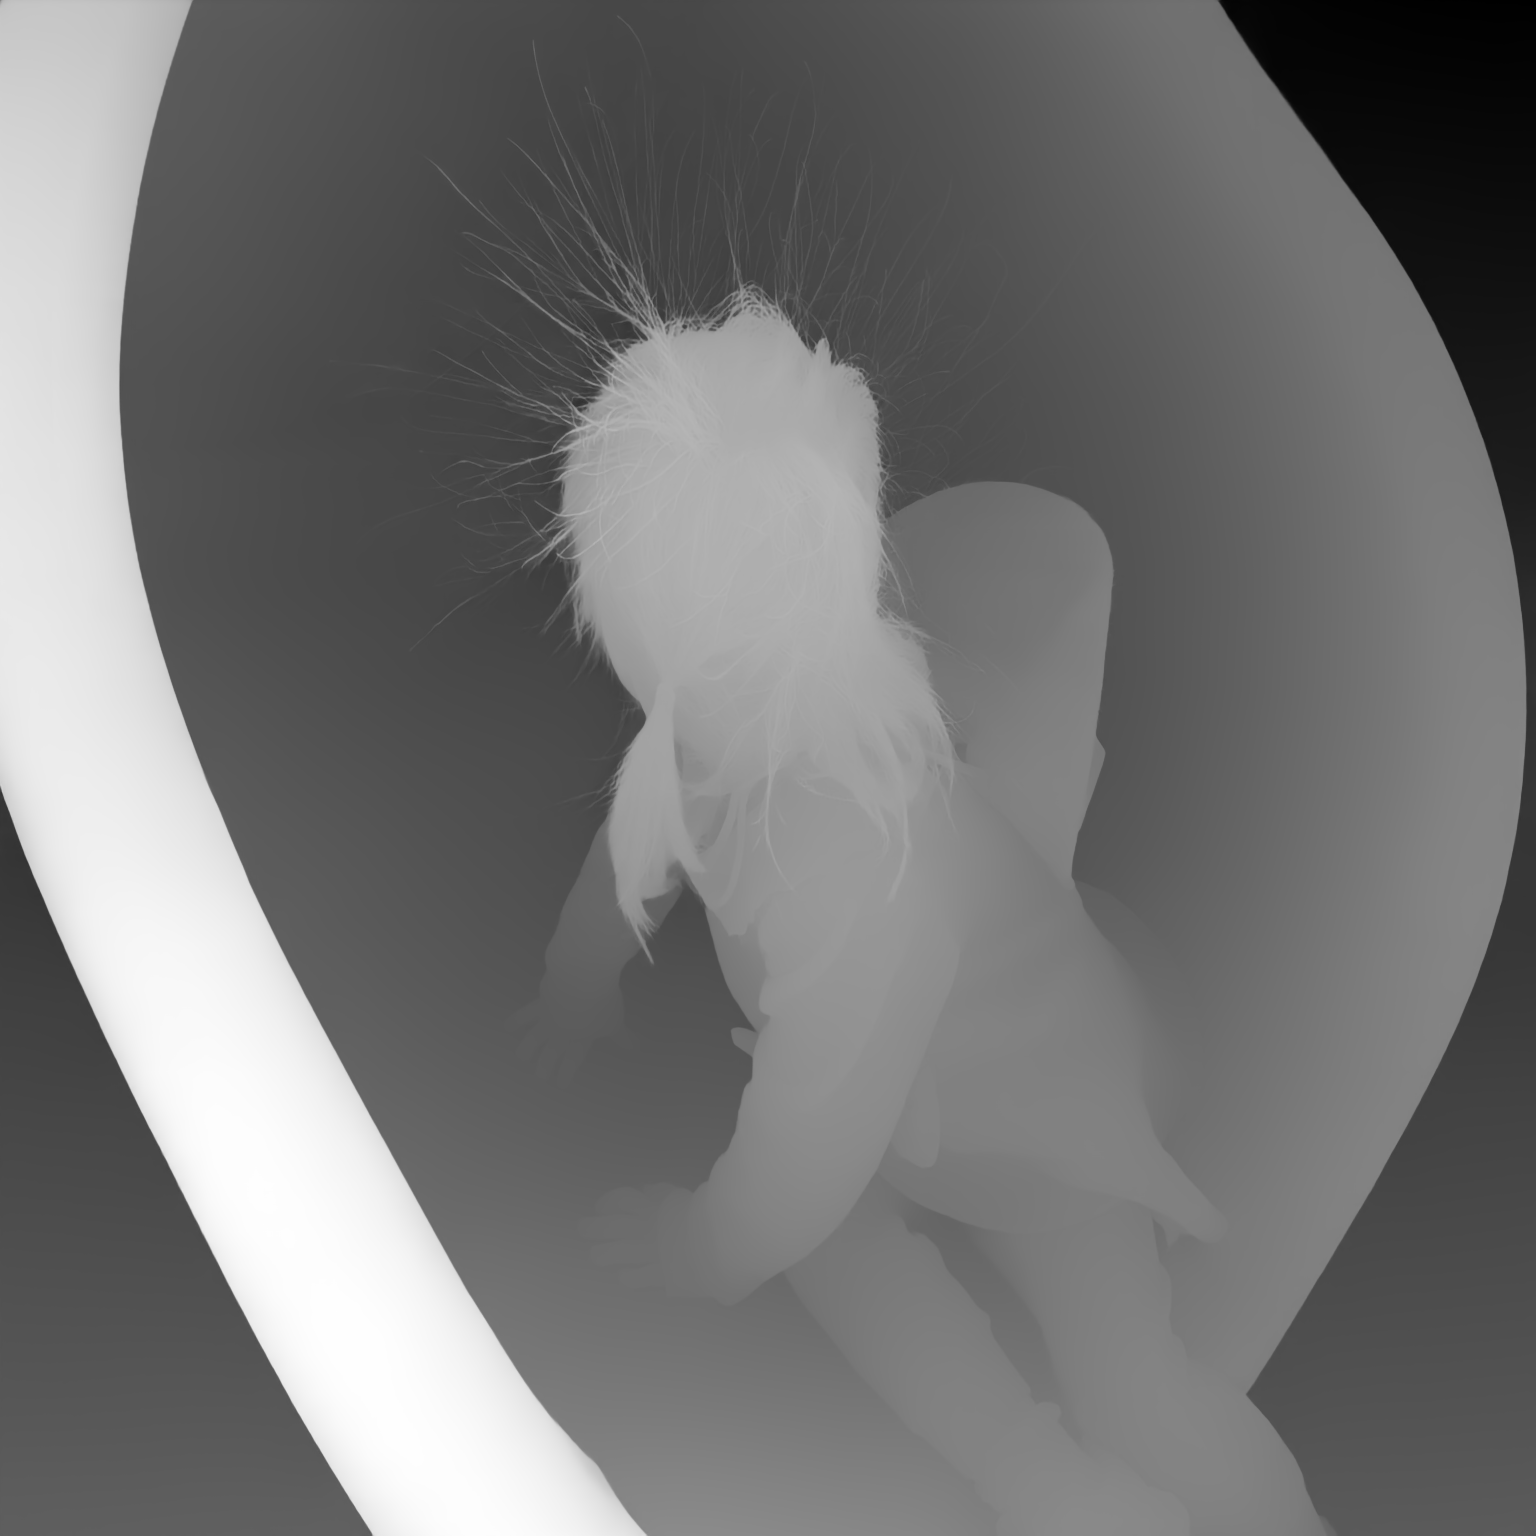

In [16]:
normalized_inverse_depth = traced_model_idn(in_image)
color_depth = (normalized_inverse_depth.cpu().numpy().squeeze()).astype(np.uint8)
display(Image.fromarray(color_depth))

Looking good! It's amazing how the model excels at fine details like the girl's hair.

## CoreML Conversion

Cool! now we have a traced model we can pass to `coremltools` for conversion.

The inputs to the model will be of two different types:
- [TensorType](https://apple.github.io/coremltools/source/coremltools.converters.mil.input_types.html#coremltools.converters.mil.input_types.TensorType), a generic tensor, for the original width information required to compute the depth in meters.
- [ImageType](https://apple.github.io/coremltools/source/coremltools.converters.mil.input_types.html#coremltools.converters.mil.input_types.ImageType), which we'll use to represent the input image. Using `ImageType` allows you to use images more efficiently in Swift, avoiding inefficient copies and conversions. [More information here](https://apple.github.io/coremltools/docs-guides/source/image-inputs.html).

We also set the minimum deployment target, `iOS18` is the latest version, and it will also allow us to do more optimizations later on.

In [17]:
ct_model = ct.convert(
    traced_model,
    inputs=[
        ct.ImageType(
            name="image",
            color_layout=ct.colorlayout.RGB,
            shape=(1, 3, 1536, 1536),
            scale=1 / 255.0,
        ),
        ct.TensorType(name="originalWidth", shape=(1, 1, 1, 1)),
    ],
    outputs=[ct.TensorType(name="depthMeters")],
    convert_to="mlprogram",
    minimum_deployment_target=ct.target.iOS18,
    compute_precision=ct.precision.FLOAT16,
)

Converting PyTorch Frontend ==> MIL Ops:  88%|████████▊ | 3434/3898 [00:01<00:00, 2149.77 ops/s]

ERROR - converting 'deg2rad' op (located at: 'fov_radians'):

Converting PyTorch Frontend ==> MIL Ops: 100%|█████████▉| 3883/3898 [00:01<00:00, 2554.12 ops/s]


RuntimeError: PyTorch convert function for op 'deg2rad' not implemented.

Hmm, It seems we got an error, `RuntimeError: PyTorch convert function for op 'deg2rad' not implemented.`. This is an operation that exists in PyTorch but not in Core ML.

We can fix it by writing our own.

In [18]:
@register_torch_op
def deg2rad(context, node):
    deg = _get_inputs(context, node, expected=1)[0]
    deg2rad_factor = mb.const(val=torch.pi / 180.0, name=node.name + "_factor")
    out = mb.mul(x=deg, y=deg2rad_factor, name=node.name)
    context.add(out)

In [19]:
ct_model = ct.convert(
    traced_model,
    inputs=[
        ct.ImageType(
            name="image",
            color_layout=ct.colorlayout.RGB,
            shape=(1, 3, 1536, 1536),
            scale=1 / 255.0,
        ),
        ct.TensorType(name="originalWidth", shape=(1, 1, 1, 1)),
    ],
    outputs=[ct.TensorType(name="depthMeters")],
    convert_to="mlprogram",
    # We can do more optimizations if we target iOS18, for more compatability lower this
    minimum_deployment_target=ct.target.iOS18,
    compute_precision=ct.precision.FLOAT16,
)

Running MIL backend_mlprogram pipeline: 100%|██████████| 12/12 [00:00<00:00, 32.82 passes/s]


Now the conversion completes without issue.

This was for the metric model. We can follow a similar process to convert the inverse depth model.

In [20]:
ct_model_idn = ct.convert(
    traced_model_idn,
    inputs=[
        ct.ImageType(
            name="image",
            color_layout=ct.colorlayout.RGB,
            shape=(1, 3, 1536, 1536),
            scale=1 / 255.0,
        ),
    ],
    outputs=[
        ct.ImageType(
            name="normalizedInverseDepth",
            color_layout=ct.colorlayout.GRAYSCALE_FLOAT16,
        )
    ],
    convert_to="mlprogram",
    # We can do more optimizations if we target iOS18, for more compatability lower this
    minimum_deployment_target=ct.target.iOS18,
    compute_precision=ct.precision.FLOAT16,
)

Running MIL backend_mlprogram pipeline: 100%|██████████| 12/12 [00:00<00:00, 46.67 passes/s]


Now let's do a quick test, just to make sure our models are working correctly.

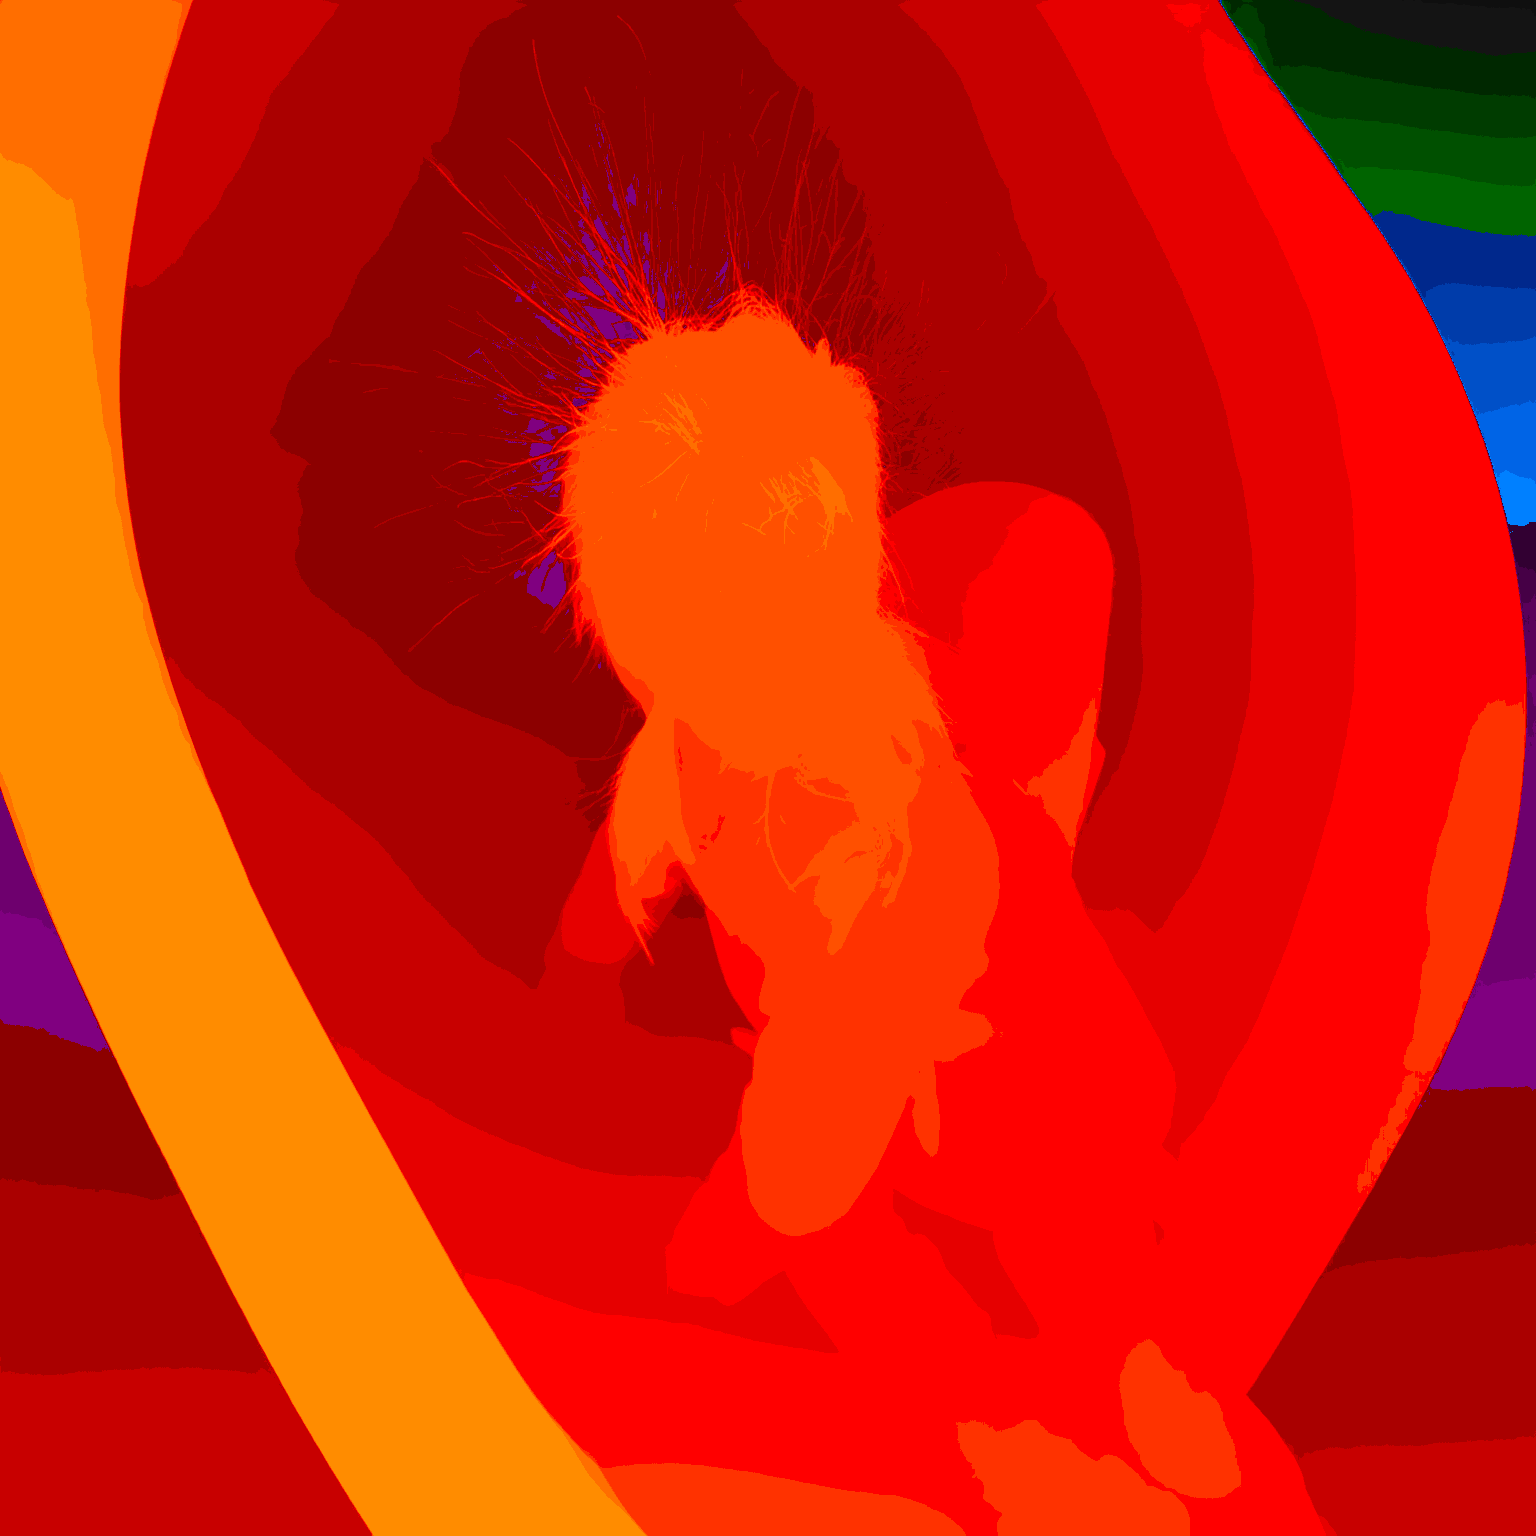

In [21]:
out = ct_model.predict(
    {
        "image": resized_image,
        "originalWidth": original_widths.cpu().numpy().astype(np.float32),
    }
)
color_map = array_to_colored_map(out["depthMeters"].squeeze())
display(Image.fromarray(color_map))

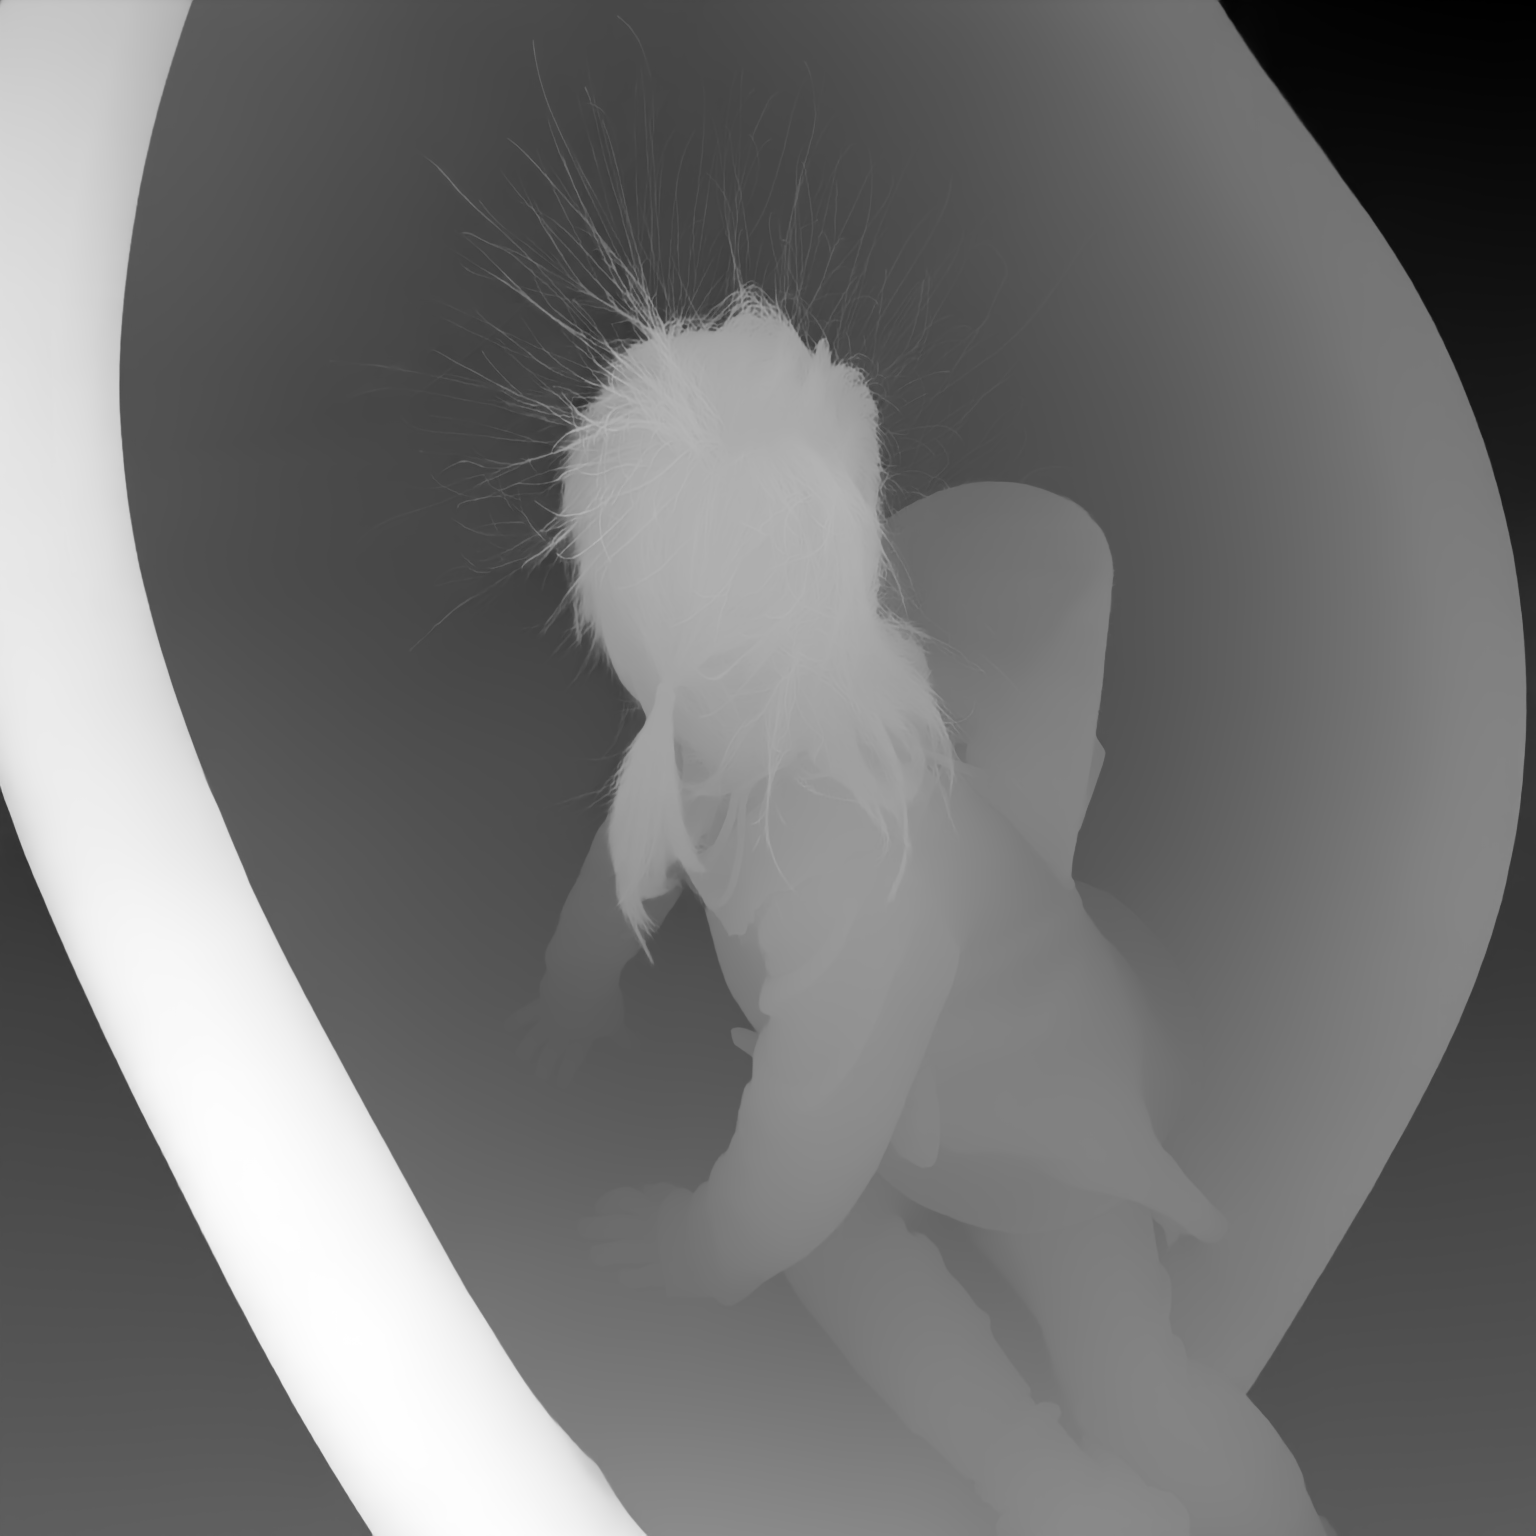

In [22]:
out = ct_model_idn.predict({"image": resized_image})
normalized_inverse_depth = out["normalizedInverseDepth"]
display(normalized_inverse_depth.convert("RGB"))

Looking good! However, Lets do a more in-depth comparison, just to be safe.

## Checkpoint 2

In [23]:
ct_model.save("DepthPro.mlpackage")
ct_model_idn.save("DepthProNormalizedInverseDepth.mlpackage")

In [ ]:
# traced_model = torch.jit.load("traced_depthpro_model.pt")
# traced_model.eval()
# traced_model = traced_model.to(device)
# traced_model_idn = torch.jit.load("traced_depthpro_model_normalized_inverse_depth.pt")
# traced_model_idn.eval()
# traced_model_idn = traced_model.to(device)

# ct_model = ct.models.MLModel("DepthPro.mlpackage")
# ct_model_idn = ct.models.MLModel("DepthProNormalizedInverseDepth.mlpackage")

## Compare

In [24]:
def display_time_stats(reference_model_time, test_model_time):
    print("reference model time", reference_model_time, "s")
    print("test model time", test_model_time, "s")
    percent_time_diff = (
        100 * abs(test_model_time - reference_model_time) / reference_model_time
    )
    print(
        "test model was",
        percent_time_diff,
        "%",
        "faster" if reference_model_time > test_model_time else "slower",
        "than reference model",
    )


def display_accuracy_stats(reference_model_output, test_model_output):
    diff = np.abs(reference_model_output - test_model_output)
    print("min", np.min(diff))
    print("median", np.median(diff))
    print("mean", np.mean(diff))
    print("max", np.max(diff))


def get_dir_size_bytes(path):
    total_size = 0
    for dirpath, _, filenames in os.walk(path):
        for filename in filenames:
            filepath = os.path.join(dirpath, filename)
            total_size += os.path.getsize(filepath)
    return total_size


def display_size_stats(reference_model_size_bytes, test_model_size_bytes):
    print("reference model size", reference_model_size_bytes * 1e-9, "GB")
    print("test model size", test_model_size_bytes * 1e-9, "GB")
    percent_time_diff = (
        100
        * abs(test_model_size_bytes - reference_model_size_bytes)
        / reference_model_size_bytes
    )
    print(
        "test model was",
        percent_time_diff,
        "%",
        "smaller" if reference_model_size_bytes > test_model_size_bytes else "larger",
        "than reference model",
    )


def time_pytorch_model(model, image):
    # perform one inference before timing to warm it up
    _ = model(image)
    pt_start_time = time.perf_counter()
    pt_out = model(image)
    pt_end_time = time.perf_counter()
    pt_elapsed_time = pt_end_time - pt_start_time

    pt_normalized_inverse_depth = pt_out.cpu().detach().numpy()

    return pt_normalized_inverse_depth, pt_elapsed_time


def time_coreml_model(model, image):
    # perform one inference before timing to warm it up
    _ = model.predict({"image": image})
    ct_start_time = time.perf_counter()
    ct_out = model.predict({"image": image})
    ct_end_time = time.perf_counter()
    ct_elapsed_time = ct_end_time - ct_start_time

    ct_normalized_inverse_depth = ct_out["normalizedInverseDepth"]

    return ct_normalized_inverse_depth, ct_elapsed_time

Perform a comparison with the original model

In [25]:
pt_model_size_bytes = os.path.getsize("traced_depthpro_model.pt")
ct_model_size_bytes = get_dir_size_bytes("DepthPro.mlpackage")

pt_normalized_depth, pt_elapsed_time = time_pytorch_model(traced_model_idn, in_image)
ct_normalized_depth, ct_elapsed_time = time_coreml_model(ct_model_idn, resized_image)

print("reference model is pytorch, test model is coreml")
display_time_stats(pt_elapsed_time, ct_elapsed_time)
display_size_stats(pt_model_size_bytes, ct_model_size_bytes)
print("depth accuracy")
display_accuracy_stats(
    pt_normalized_depth / 255.0, np.array(ct_normalized_depth) / 255.0
)


reference model is pytorch, test model is coreml
reference model time 12.949117959011346 s
test model time 3.4921722910075914 s
test model was 73.03158174895323 % faster than reference model
reference model size 3.811293855 GB
test model size 1.902515337 GB
test model was 50.082166073232365 % smaller than reference model
depth accuracy
min 0.0
median 0.0002541542
mean 0.000311057
max 0.0043649673


Before we move on, let's quickly profile the models to see what hardware they are running on. For this let's use [CoreMLProfiler](https://github.com/FL33TW00D/coremlprofiler), a tool we developed for this purpose.

In [ ]:
profiler = CoreMLProfiler("DepthPro.mlpackage")
print(profiler.device_usage_summary_chart())

Compute Unit Mapping
██████████████████████████████████████████████████
All: 1989  ■ CPU: 0  ■ GPU: 0  ■ ANE: 1989  


In [ ]:
profiler = CoreMLProfiler("DepthProNormalizedInverseDepth.mlpackage")
print(profiler.device_usage_summary_chart())

Compute Unit Mapping
█████████████████████████████████████████████████
All: 1498  ■ CPU: 2  ■ GPU: 0  ■ ANE: 1496  


Looks like most of the operations are running on the Neural Engine (ANE), which is great because it ensures compatibility and efficiency across all Apple Silicon devices. On some Macs, the ANE can be slower than the GPU, but is much more power-efficient and does not get hot quickly. On iPhone, the ANE is usually the best compute device to use, although it sometimes requires some effort to ensure converted models are compatible with it.

Matthijs Hollemans wrote a [nice overview](https://github.com/hollance/neural-engine/blob/master/docs/why-care.md) that is a bit old, but some of the points are still valid.

Even though the model is fully compatible with ANE, we can decide at runtime whether we want to use the GPU instead, or let the system decide the best hardware combination.

## Optimizations

There are many different optimizations we can do after converting models to Core ML. These are called post-training optimizations because, unlike other methods, they don't require changes to the training process or additional fine-tuning. Some of the most common include:

- Pruning
    - Making our tensors more sparse by making the weights which are close to zero, equal to zero.
    - Generally you can define a target sparsity, which tells the optimizer what percent of the weights should be removed. You can think about it like sorting all the weights in a tensor by their absolute value and removing the bottom target %. 
- Palettization
    - Turn our weight matrices into matrices that store indices into a look up table (LUT). Usually the LUT contains 16 or so entries, but it can be bigger or smaller.
    - The entries in the LUT are commonly decided by doing clustering on the weights (usually k-means) in a particular tensor and storing the centroids. You can also choose to split the tensor into pieces with a unique LUT.
- Quantization
    - For each weight we classify it into a few pre-defined bins. This is similar to palettization, but the entries in the LUT are decided before optimization.

In [26]:
def prune(ct_model):
    op_config = cto.coreml.OpMagnitudePrunerConfig(target_sparsity=0.10)
    config = cto.coreml.OptimizationConfig(global_config=op_config)
    mlmodel_pruned = cto.coreml.prune_weights(ct_model, config=config)
    return mlmodel_pruned


def palletize(ct_model, joint_compression=False):
    op_config = cto.coreml.OpPalettizerConfig(nbits=4)
    config = cto.coreml.OptimizationConfig(global_config=op_config)
    mlmodel_palettized = cto.coreml.palettize_weights(
        ct_model, config, joint_compression=joint_compression
    )
    return mlmodel_palettized


def quantize(ct_model, joint_compression=False):
    op_config = cto.coreml.OpLinearQuantizerConfig(
        mode="linear_symmetric", granularity="per_tensor"
    )
    linear_weight_quantize_config = cto.coreml.OptimizationConfig(
        global_config=op_config
    )

    mlmodel_quantized = cto.coreml.linear_quantize_weights(
        ct_model, linear_weight_quantize_config, joint_compression=joint_compression
    )

    return mlmodel_quantized

We can also combine differnt optimization strategies. CoreML's own documentation goes over it [here](https://apple.github.io/coremltools/docs-guides/source/opt-joint-compression.html).

In [27]:
ct_model_pruned_quantized = prune(ct_model)
ct_model_pruned_quantized = quantize(ct_model_pruned_quantized, joint_compression=True)

Running compression pass prune_weights: 100%|██████████| 1015/1015 [00:17<00:00, 56.41 ops/s]
Running MIL frontend_milinternal pipeline: 0 passes [00:00, ? passes/s]
Running compression pass linear_quantize_weights: 100%|██████████| 1363/1363 [00:17<00:00, 76.04 ops/s]
Running MIL frontend_milinternal pipeline: 0 passes [00:00, ? passes/s]
Running MIL backend_mlprogram pipeline: 100%|██████████| 12/12 [00:00<00:00, 30.35 passes/s]


In [28]:
ct_model_pruned_quantized_idn = prune(ct_model_idn)
ct_model_pruned_quantized_idn = quantize(
    ct_model_pruned_quantized_idn, joint_compression=True
)

Running compression pass prune_weights: 100%|██████████| 664/664 [00:12<00:00, 55.22 ops/s]
Running MIL frontend_milinternal pipeline: 0 passes [00:00, ? passes/s]
Running compression pass linear_quantize_weights: 100%|██████████| 910/910 [00:12<00:00, 74.06 ops/s] 
Running MIL frontend_milinternal pipeline: 0 passes [00:00, ? passes/s]
Running MIL backend_mlprogram pipeline: 100%|██████████| 12/12 [00:00<00:00, 32.06 passes/s]


Give it a test

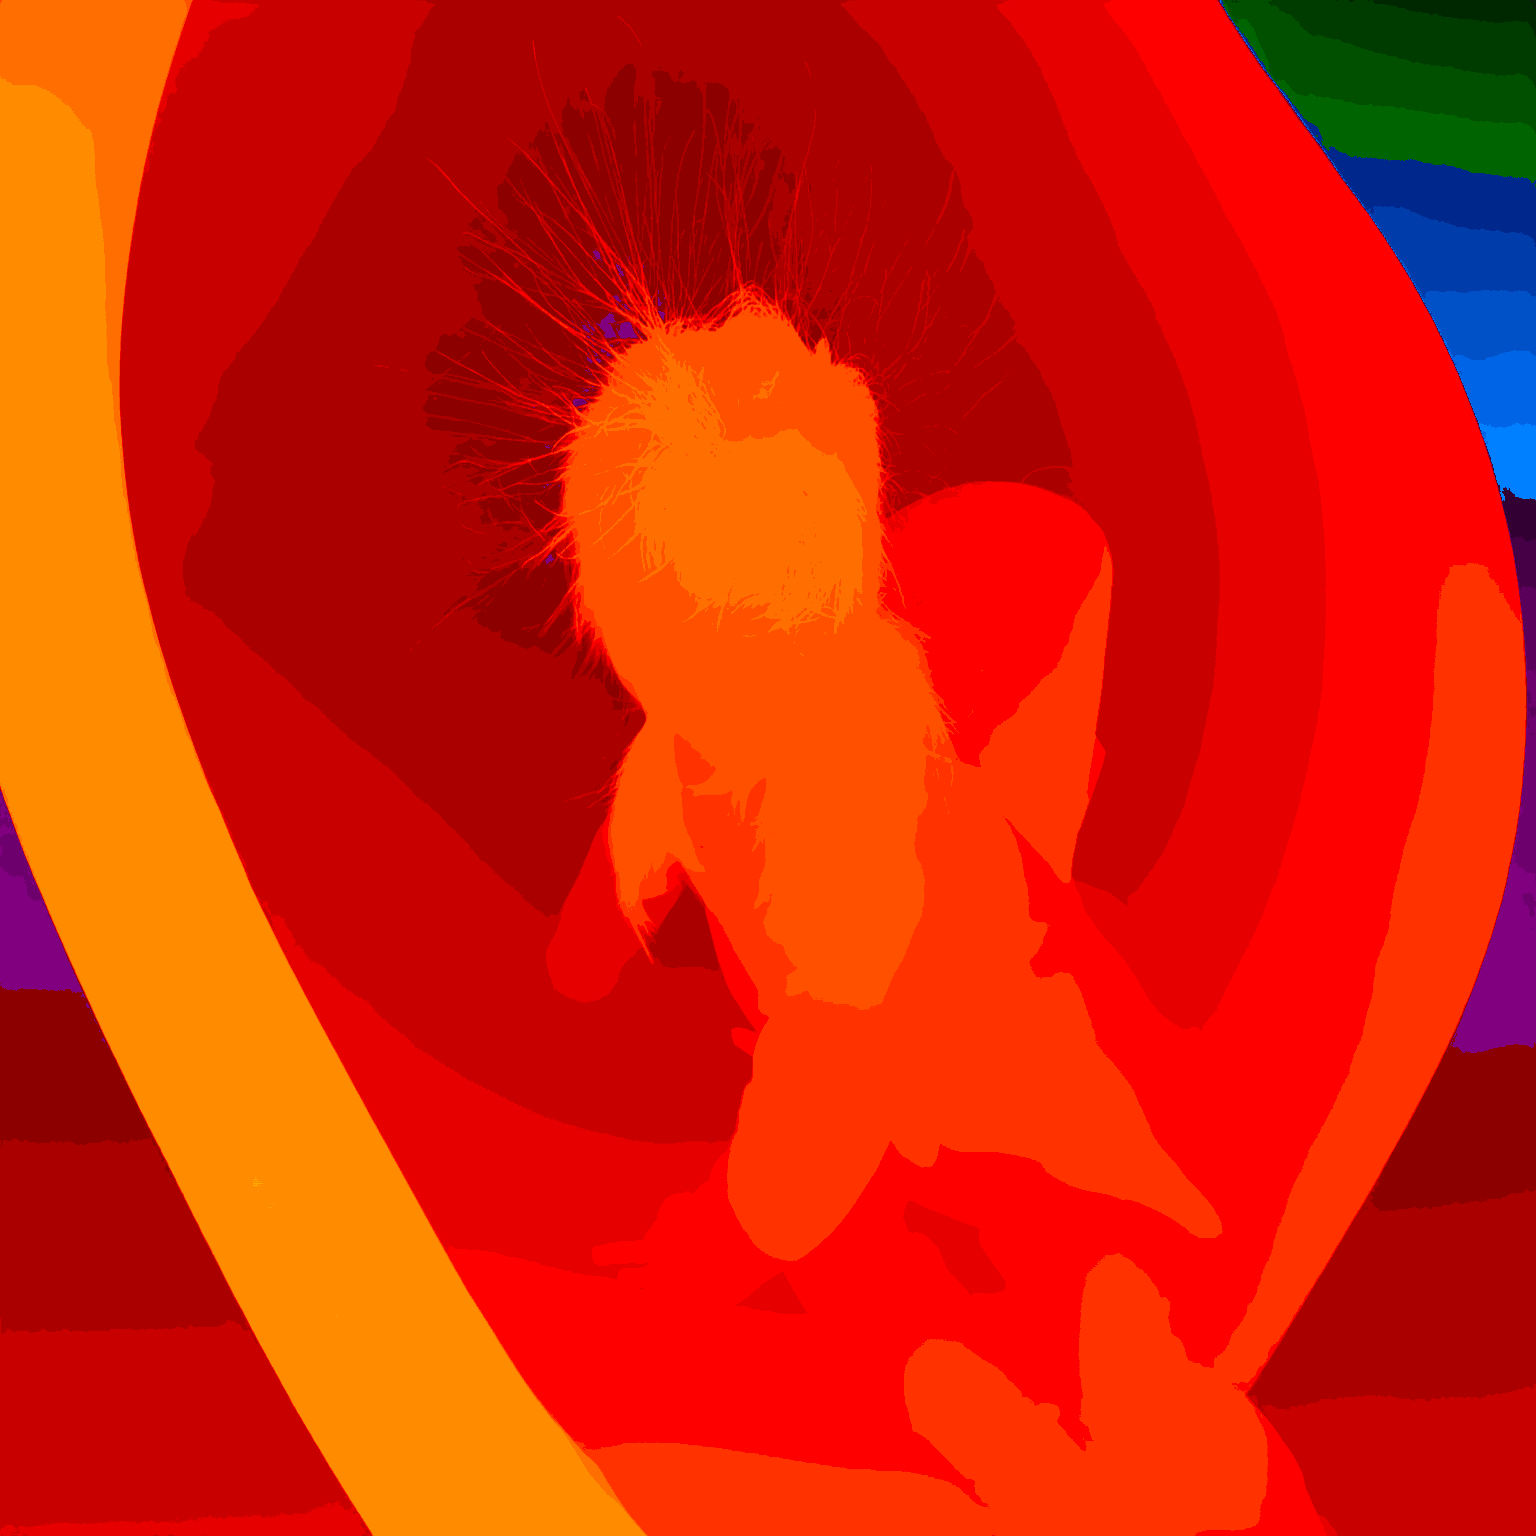

In [29]:
out = ct_model_pruned_quantized.predict(
    {
        "image": resized_image,
        "originalWidth": original_widths.cpu().numpy().astype(np.float32),
    }
)
color_map = array_to_colored_map(out["depthMeters"].squeeze())
display(Image.fromarray(color_map))

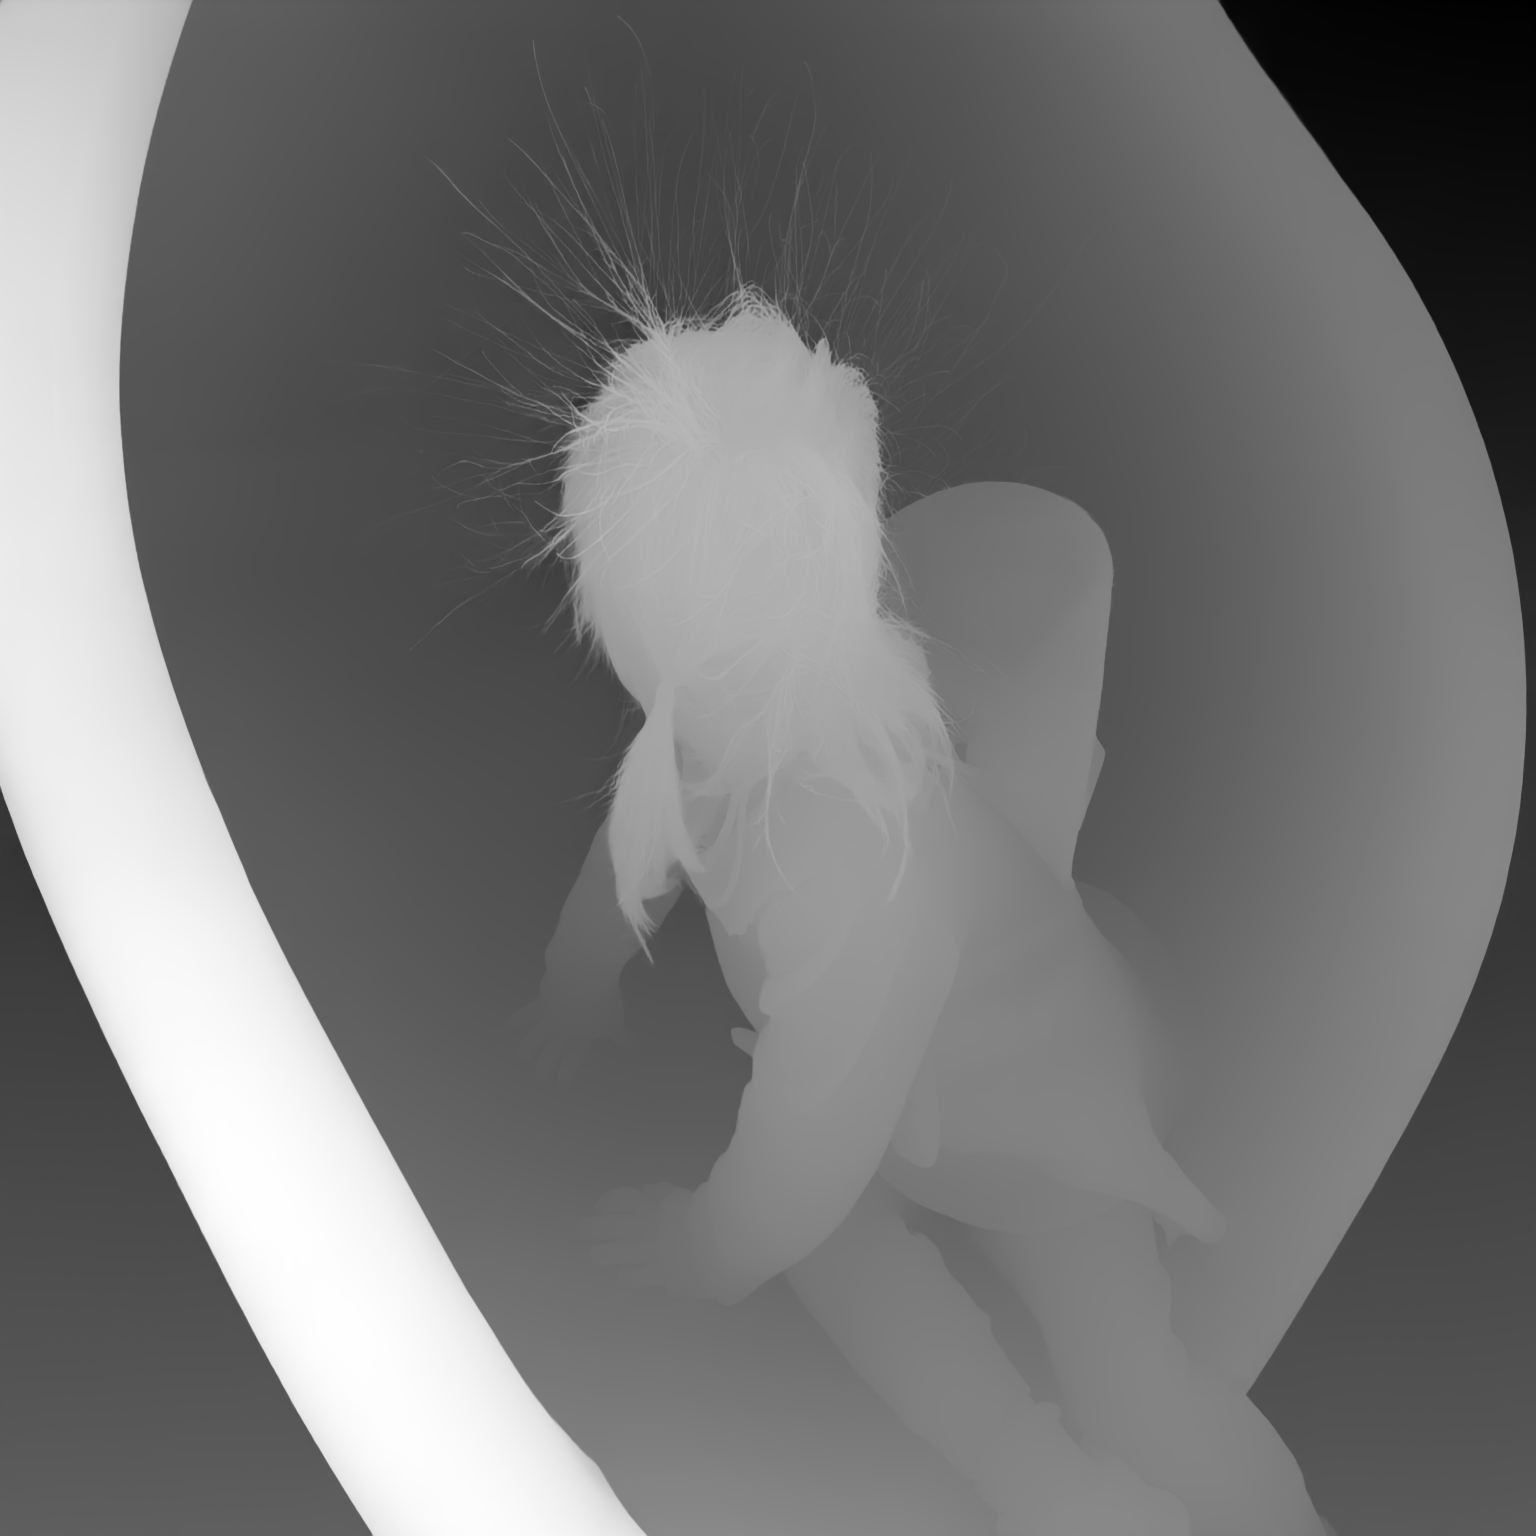

In [30]:
out = ct_model_pruned_quantized_idn.predict({"image": resized_image})
normalized_inverse_depth = out["normalizedInverseDepth"]
display(normalized_inverse_depth.convert("RGB"))

## Checkpoint 3

In [31]:
ct_model_pruned_quantized.save("DepthProPrunedQuantized.mlpackage")
ct_model_pruned_quantized_idn.save(
    "DepthProNormalizedInverseDepthPrunedQuantized.mlpackage"
)

In [ ]:
# traced_model = torch.jit.load("traced_depthpro_model.pt")
# traced_model.eval()
# traced_model = traced_model.to(device)
# traced_model_idn = torch.jit.load("traced_depthpro_model_normalized_inverse_depth.pt")
# traced_model_idn.eval()
# traced_model_idn = traced_model.to(device)

# ct_model = ct.models.MLModel("DepthPro.mlpackage")
# ct_model_idn = ct.models.MLModel("DepthProNormalizedInverseDepth.mlpackage")
# ct_model_pruned_quantized = ct.models.MLModel("DepthProPrunedQuantized.mlpackage")
# ct_model_pruned_quantized_idn = ct.models.MLModel("DepthProNormalizedInverseDepthPrunedQuantized.mlpackage")

## Compare

In [32]:
ct_model_size_bytes = get_dir_size_bytes(
    "DepthProNormalizedInverseDepth.mlpackage"
)
ct_opt_model_size_bytes = get_dir_size_bytes(
    "DepthProNormalizedInverseDepthPrunedQuantized.mlpackage"
)

ct_normalized_depth, ct_elapsed_time = time_coreml_model(ct_model_idn, resized_image)
ct_opt_normalized_depth, ct_opt_elapsed_time = time_coreml_model(
    ct_model_pruned_quantized_idn, resized_image
)

print("reference model is coreml, test model is coreml pruned quantized")
display_time_stats(ct_elapsed_time, ct_opt_elapsed_time)
display_size_stats(ct_model_size_bytes, ct_opt_model_size_bytes)
print("depth accuracy")
display_accuracy_stats(
    np.array(ct_normalized_depth) / 255.0, np.array(ct_opt_normalized_depth) / 255.0
)

reference model is coreml, test model is coreml pruned quantized
reference model time 3.4949274999962654 s
test model time 3.240509709023172 s
test model was 7.279630005868941 % faster than reference model
reference model size 1.293756288 GB
test model size 0.745003297 GB
test model was 42.41548397405741 % smaller than reference model
depth accuracy
min 0.0
median 0.0039215684
mean 0.004878684
max 0.061274514


Nice, this is running 7% faster than the `float16` version, at almost half the size. The accuracy is not as great, but it's close enough for most purposes.

In [ ]:
profiler = CoreMLProfiler("DepthProPrunedQuantized.mlpackage")
print(profiler.device_usage_summary_chart())

Compute Unit Mapping
██████████████████████████████████████████████████
All: 1989  ■ CPU: 0  ■ GPU: 0  ■ ANE: 1989  


In [ ]:
profiler = CoreMLProfiler(
    "DepthProNormalizedInverseDepthPrunedQuantized.mlpackage"
)
print(profiler.device_usage_summary_chart())

Compute Unit Mapping
█████████████████████████████████████████████████
All: 1498  ■ CPU: 2  ■ GPU: 0  ■ ANE: 1496  


## Metadata

It's always a good practice to include metadata fields for appropriate attribution and documentation.

It also helps a lot when working with Xcode, because we can enable the built-in preview widgets.

In [33]:
ct_model_pruned_quantized.name = "DepthPro (Pruned 10%, Quantized Linear)"
ct_model_pruned_quantized.version = "1.0"
ct_model_pruned_quantized.short_description = (
    "DepthPro is a state-of-the-art model for monocular depth estimation"
)
ct_model_pruned_quantized.author = "Original Paper: Depth Pro: Sharp Monocular Metric Depth in Less Than a Second (Bochkovskii et al.)"
ct_model_pruned_quantized.license = "Apple Public Source License"
ct_model_pruned_quantized.input_description["image"] = (
    "Input image whose depth will be estimated."
)
ct_model_pruned_quantized.input_description["originalWidth"] = (
    "Original widths of images before resizing."
)
ct_model_pruned_quantized.output_description["depthMeters"] = (
    "Estimated depth in meters,"
)

ct_model_pruned_quantized_idn.name = (
    "DepthPro Normalized Inverse Depth (Pruned 10%, Quantized Linear)"
)
ct_model_pruned_quantized_idn.version = "1.0"
ct_model_pruned_quantized_idn.short_description = (
    "DepthPro is state of the art for monocular depth estimation"
)
ct_model_pruned_quantized_idn.author = "Original Paper: Depth Pro: Sharp Monocular Metric Depth in Less Than a Second (Bochkovskii et al.)"
ct_model_pruned_quantized_idn.license = "Apple Public Source License"
ct_model_pruned_quantized_idn.input_description["image"] = (
    "Input image whose depth will be estimated."
)
ct_model_pruned_quantized_idn.output_description["normalizedInverseDepth"] = (
    "Estimated depth from white(closest) to black(furthest)"
)

We want to [let the model know](https://apple.github.io/coremltools/docs-guides/source/xcode-model-preview-types.html) this is a depth estimation model.

In [34]:
ct_model_pruned_quantized_idn.user_defined_metadata[
    "com.apple.coreml.model.preview.type"
] = "depthEstimation"

In [ ]:
ct_model_pruned_quantized.save("DepthProPrunedQuantized.mlpackage")
ct_model_pruned_quantized_idn.save(
    "DepthProNormalizedInverseDepthPrunedQuantized.mlpackage"
)

Now that we've added the `depthEstimation` line, we can open `depthpro_pruned_quantized_inverse_depth_normalized.mlpackage` in Xcode and look at images with the preview functionality.

![XCode Preview](images/Xcode_preview.png)

## Checking Performance

Let's check the performance of our optimized model on the different hardware configurations.

### CPU

![](images/cpu_perf.png)

### CPU + GPU

![](images/gpu_perf.png)

### CPU + ANE

![](images/ane_perf.png)

On my Mac, the GPU was fastest. On an iPhone, however, the ANE may be faster, and it will also use less power.

I wrote a small program, `depth_pro_powermetrics_test.py` using [CapturePowermetrics](https://github.com/greenrazer/capture-powermetrics), to analyze power use. It requires `sudo` so we cannot run it inside the notebook, but here are the results I got:

CPU + GPU:
```
cpu energy: 12.456 J
gpu energy: 50.122 J
ane energy: 0.0 J
```
```
cpu energy: 0.146 J
gpu energy: 39.215 J
ane energy: 0.0 J
```
```
cpu energy: 0.2215 J
gpu energy: 39.732 J
ane energy: 0.0 J
```

CPU + ANE:
```
cpu energy: 0.3 J
gpu energy: 0.0 J
ane energy: 11.155 J
```
```
cpu energy: 2.6695 J
gpu energy: 0.023 J
ane energy: 10.6295 J
```
```
cpu energy: 0.314 J
gpu energy: 0.0 J
ane energy: 10.35 J
```

Average GPU Energy: $(50.122 + 39.215 + 39.732)/3 = 43.023 \text{J}$

Average ANE Energy: $(11.155 + 10.6295 + 10.35)/3 = 10.7115 \text{J}$

The ANE uses ~75% less energy than the GPU while only being ~50% slower in this particular device. The ANE is still ~90% faster than the CPU alone.

One last experiement is measuring the energy on our optimized model. This time we will measure over the course of 10 predictions.

CPU + GPU:
```
cpu energy: 9.945 J
gpu energy: 807.985 J
ane energy: 0.0 J
```

CPU + ANE:
```
cpu energy: 8.429 J
gpu energy: 0.5670000000000001 J
ane energy: 142.0985 J
```

Now the ANE uses ~82% less energy than the GPU, while still only being ~50% slower.

A energy sampling library for mac that doesn't need sudo can be found at [WattKit](https://github.com/FL33TW00D/wattkit)

## Upload To The Hub

[huggingface model upload](https://huggingface.co/docs/hub/en/models-uploading)

[huggingface cli tutorial](https://huggingface.co/docs/huggingface_hub/en/guides/cli)

1. Login or create a huggingface account
2. Get a [User Access Token](https://huggingface.co/docs/hub/security-tokens) from your [Settings page](https://huggingface.co/settings/tokens).
3. Login to the `huggingface-cli`

In [ ]:
!huggingface-cli login

4. upload models to huggingface hub

In [ ]:
!huggingface-cli upload depthpro-coreml DepthPro.mlpackage DepthProNormalizedInverseDepth.mlpackage DepthProNormalizedInverseDepthPrunedQuantized.mlpackage DepthProPrunedQuantized.mlpackage/

The uploaded files from this tutorial are at [KeighBee/coreml-DepthPro](https://huggingface.co/KeighBee/coreml-DepthPro)